In [102]:
import numpy as np
import transforms3d as tf_transformations
import matplotlib.pyplot as plt

In [103]:
K = np.load('/home/ria/Capstone/drone_ws/src/visual_servoing/visual_servoing/cameraK.npy')
gain = 1 # tune later
prev_ev = np.zeros((8,1))
prev_v = np.zeros((4,1))
delta_t = 1
depth = None

In [104]:
pose = np.array([0, 0, 1])

In [105]:
def get_virtual_image_coordinates(u, v, Z):
        '''
        args:
            u, v: regular image coordinates
            Z: depth
        return:
            u_v, v_v: virtual image coordinates
            Z_v: depth of virtual image plane
        '''
        X = u*Z
        Y = v*Z

        cam_coords = np.array([[X], [Y], [Z]])

        r, p, y = 0, 0, 0
        cy = np.cos(y)
        sy = np.sin(y)
        cp = np.cos(p)
        sp = np.sin(p)
        cr = np.cos(r)
        sr = np.sin(r)
        C = np.array([[cy, cy*sp*sr-sy*cr, cy*sp*cr+sy*sr],
                     [sy*cp, sy*sp*sr+cy*cr, sy*sp*cr-cy*sr],
                     [-sp, cp*sr, cp*cr]])
        
        virtual_coords = C@cam_coords

        X_v = virtual_coords[0]
        Y_v = virtual_coords[1]
        Z_v = virtual_coords[2]
        u_v = X_v/Z_v
        v_v = Y_v/Z_v

        return u_v.item(), v_v.item(), Z_v.item()

def jacobian(u_v, v_v, Z_v):
    '''obs: 2x1 np array'''
    J = np.array([[-1/Z_v, 0, u_v/Z_v, v_v],
                [0, -1/Z_v, v_v/Z_v, -u_v]], dtype=np.float64)
    return J

def get_control_velocity(obs, des):
    '''
    obs: 2xn array of the pt coords in camera frame
    des: 2xn array of desired pt coords in image coordinates
    depths: nx0
    v: 4x1
    '''
    global prev_ev, prev_v
    # velocity control input
    v = np.zeros((4, 1))

    # number of points
    n = 4

    # TO-DO: vectorize this part?
    # Calculate error
    f = K[0,0] # assuming for now xy focal lengths are the same
    cx = K[0,2]
    cy = K[1,2]

    u_i = (obs[0, 0] - cx) / f
    v_i = (obs[1, 0] - cy) / f
    u_v, v_v, Z_v = get_virtual_image_coordinates(u_i, v_i, pose[2])
    J = jacobian(u_v, v_v, Z_v)
    u_di = (des[0, 0] - cx) / f
    v_di = (des[1, 0] - cy) / f
    u_dv, v_dv, Z_dv = get_virtual_image_coordinates(u_di, v_di, pose[2])
    ev = np.array([[u_v],[v_v]]) - np.array([[u_dv],[v_dv]])
    print(ev.shape)
    for i in range(1, n):
        u_i = (obs[0, i] - cx) / f
        v_i = (obs[1, i] - cy) / f
        u_v, v_v, Z_v = get_virtual_image_coordinates(u_i, v_i, pose[2])
        J = np.vstack((J, jacobian(u_v, v_v, Z_v)))

        u_di = (des[0, i] - cx) / f
        v_di = (des[1, i] - cy) / f
        u_dv, v_dv, Z_dv = get_virtual_image_coordinates(u_di, v_di, pose[2])
        ev_new = np.array([[u_v],[v_v]]) - np.array([[u_dv],[v_dv]])
        ev = np.vstack((ev, ev_new))

    # Estimate motion error
    print(ev.shape)
    print(prev_ev.shape)
    delta_ev = (ev - prev_ev) / (delta_t -  np.dot(J, prev_v))

    # Get pseudoinverse
    print(J.shape)
    J_inv = np.dot(np.linalg.inv(np.dot(np.transpose(J),J)),np.transpose(J))
    
    # Compute v
    print(J_inv.shape)
    print(ev.shape)
    print(delta_ev.shape)
    v = -gain * np.dot(J_inv, ev) - np.dot(J_inv, delta_ev)

    # Save values for next iteration
    prev_ev = ev
    prev_v = v

    return v

In [106]:
des = np.array([[25, 25,-25,-25],[25, -25, 25, -25]])
obs = des + np.array([[50], [100]])
print(des)
print(obs)

[[ 25  25 -25 -25]
 [ 25 -25  25 -25]]
[[ 75  75  25  25]
 [125  75 125  75]]


In [107]:
v = get_control_velocity(obs, des)

(2, 1)
(8, 1)
(8, 1)
(8, 4)
(4, 8)
(8, 1)
(8, 1)


In [108]:
print(v)

[[ 2.56153573e-01]
 [ 5.12307146e-01]
 [-3.10494541e-16]
 [ 1.14110022e-15]]


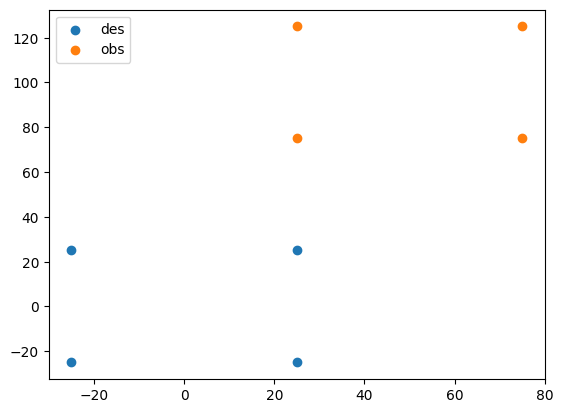

In [109]:
plt.scatter(des[0], des[1], label="des")
plt.scatter(obs[0], obs[1], label="obs")

plt.legend()

In [111]:
K = np.load('/home/ria/Capstone/drone_ws/src/visual_servoing/visual_servoing/cameraK.npy')
gain = 1 # tune later
prev_ev = np.zeros((2,1))
prev_v = np.zeros((2,1))
delta_t = 1
depth = None

In [112]:
def get_virtual_image_coordinates(u, v, Z):
        '''
        args:
            u, v: regular image coordinates
            Z: depth
        return:
            u_v, v_v: virtual image coordinates
            Z_v: depth of virtual image plane
        '''
        X = u*Z
        Y = v*Z

        cam_coords = np.array([[X], [Y], [Z]])

        r, p, y = 0, 0, 0
        cy = np.cos(y)
        sy = np.sin(y)
        cp = np.cos(p)
        sp = np.sin(p)
        cr = np.cos(r)
        sr = np.sin(r)
        C = np.array([[cy, cy*sp*sr-sy*cr, cy*sp*cr+sy*sr],
                     [sy*cp, sy*sp*sr+cy*cr, sy*sp*cr-cy*sr],
                     [-sp, cp*sr, cp*cr]])
        
        virtual_coords = C@cam_coords

        X_v = virtual_coords[0]
        Y_v = virtual_coords[1]
        Z_v = virtual_coords[2]
        u_v = X_v/Z_v
        v_v = Y_v/Z_v

        return u_v.item(), v_v.item(), Z_v.item()

def jacobian(u_v, v_v, Z_v):
    '''obs: 2x1 np array'''
    J = np.array([[-1/Z_v, 0],
                [0, -1/Z_v]], dtype=np.float64)
    return J

def get_control_velocity(obs, des):
    '''
    obs: 2xn array of the pt coords in camera frame
    des: 2xn array of desired pt coords in image coordinates
    depths: nx0
    v: 4x1
    '''
    global prev_ev, prev_v
    # velocity control input
    v = np.zeros((4, 1))

    # number of points
    n = 4

    # TO-DO: vectorize this part?
    # Calculate error
    f = K[0,0] # assuming for now xy focal lengths are the same
    cx = K[0,2]
    cy = K[1,2]

    u_i = (obs[0, 0] - cx) / f
    v_i = (obs[1, 0] - cy) / f
    u_v, v_v, Z_v = get_virtual_image_coordinates(u_i, v_i, pose[2])
    J = jacobian(u_v, v_v, Z_v)
    u_di = (des[0, 0] - cx) / f
    v_di = (des[1, 0] - cy) / f
    u_dv, v_dv, Z_dv = get_virtual_image_coordinates(u_di, v_di, pose[2])
    ev = np.array([[u_v],[v_v]]) - np.array([[u_dv],[v_dv]])
    print(ev.shape)

    # Estimate motion error
    print(ev.shape)
    print(prev_ev.shape)
    delta_ev = (ev - prev_ev) / (delta_t -  np.dot(J, prev_v))

    # Get pseudoinverse
    print(J.shape)
    J_inv = np.dot(np.linalg.inv(np.dot(np.transpose(J),J)),np.transpose(J))
    
    # Compute v
    print(J_inv.shape)
    print(ev.shape)
    print(delta_ev.shape)
    v = -gain * np.dot(J_inv, ev) - np.dot(J_inv, delta_ev)

    # Save values for next iteration
    prev_ev = ev
    prev_v = v

    return v

In [114]:
des = np.array([[0],[0]])
obs = des + np.array([[50], [100]])
print(des)
print(obs)


[[0]
 [0]]
[[ 50]
 [100]]


In [115]:
v = get_control_velocity(obs, des)
print(v)

(2, 1)
(2, 1)
(2, 1)
(2, 2)
(2, 2)
(2, 1)
(2, 1)
[[0.25615357]
 [0.51230715]]
